<img align="center" width="12%" style="padding-right:10px;" src="../Images/Ccom.png">

# Lab A Step 3 Integrating the Data
<a href="https://piazza.com/class/jzvaaav18cf2j7"><img src="../Images/help.png"  title="Ask questions on Piazza.com" align="right" width="10%" alt="Piazza.com\"></a><br><br> 

In this step you will combine the sensor data to create an integrated depth solution. that is we combine the two way travel times together with all the data required to transform it into a depth relative to the chart datum. We already have the means of importing and handling all the data streams, but we do not yet have a mechanism to integrate them. For the integration we will need to know where the sensors are in relation to each other, which we will handle through a **Vessel** class, and we also will need to combine the observations which we will handle through an **Integration** class

The integration consists of determining the positions of the transducers at both transmit and reception time and then finding the location of the seafloor relative to it. This implies that we need to have a mechanism of determining all the sensor values at transmit and receipt time, but since the sensors are asynchronous it is unlikely that there are data at these exact epochs. Thus we first need to interpolate the various data. We also need to determine the position of the sensors at the time of transmit and receipt with respect to each other, which implies that we have to do a transformation of the Vessel lever arms and also transform them to geo-referenced coordinates. Finally you will need to transform the **twtt** to a distance and offset this from the position of the transducers to determine the depth, which means that there needs to be a method of transforming twtt to distance.


___

## 3.0 Import all The Data

In [15]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt

from mycode.EchosounderData import EchosounderData
from mycode.Motion import Motion
from mycode.SSP import SSP
from mycode.waterlevel import WaterLevel
from mycode.vessel import Vessel
from mycode.position import Position

sys.path.append(os.getcwd())  # add the current folder to the list of paths where Python looks for modules 

# Get the data path
abs_path = os.path.abspath(os.path.curdir)

# TWTTs
twtt = EchosounderData()
twtt.read_jhc_file(abs_path+'/Data/Lab_A_TWTT.txt')

# positions
pos = Position()
pos.read_jhc_file(abs_path+'/Data/Lab_A_GNSS.txt')
# make sure that there is Cartesian representation of the positions
pos.carto_project('utm','ortho')

# Motion data
motions = Motion()
motions.read_jhc_file(abs_path+'/Data/Lab_A_MRU.txt')

# Water level data
water_levels = WaterLevel()
water_levels.read_jhc_file(abs_path+'/Data/Lab_A_TIDE.txt')

# Sound speed data
sound_speed_profile = SSP()
sound_speed_profile.read_jhc_file(abs_path+'/Data/Lab_A_SVP.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening Two Way Travel Time (TWTT) data file:/home/jupyter-semmed/ESCI_OE_774_874/Lab_A/Data/Lab_A_TWTT.txt
Opening GNSS data file:/home/jupyter-semmed/ESCI_OE_774_874/Lab_A/Data/Lab_A_GNSS.txt
+proj=utm +zone=55 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs
Opening motion data file:/home/jupyter-semmed/ESCI_OE_774_874/Lab_A/Data/Lab_A_MRU.txt
Opening water level data file:/home/jupyter-semmed/ESCI_OE_774_874/Lab_A/Data/Lab_A_TIDE.txt
Opening sound speed profile data file:/home/jupyter-semmed/ESCI_OE_774_874/Lab_A/Data/Lab_A_SVP.txt


The code cell above imports all classes for the handling of data from all the sensors required to create bathymetry data. However, we do not yet have a mechanism to integrate the data. 

<br><br><img align="center" width="60%" style="padding-right:10px;" src="../Images/usns_henson.png"><br><br>

The data provided here was collected by the USNS Henson, a 100m long hydrographic survey vessel. It operates an EM710  Multibeam which is mounted in a gondola about 7m below the water line. It uses a POS/MV 320 for orientation. The available Ellipsoid referencing is from a NavCom (C-Nav) receiver generating 1Hz RTG heights from the masthead. 

As you have seen in the previous labs the vessel was operating in ~ 100m water in open ocean conditions in the Western Pacific. The data is from a ~ 1⁄2 hour period when the vessel was steaming at ~ 12 knots and undertook a 180 degree turn.

For this lab you will navigate the transmitter and receiver of a multibeam for the case of a (near) vertically oriented beam. This special case may be treated as a (narrow beam) single beam echo sounder through ignoring the array-relative angles of transmission and reception.

___
## 3.1 Implementing A Ship's Reference Frame 

The sensors acquiring the three sets of observations (sonar-relative range, position and orientation) are not co-located. Thus you must allow for the lever arms between the sensors. For example, here the relative Ship's Reference Frame (SRF) offsets of the transmitter, receiver and GPS antenna are provided.

For this lab we will also assume that the orientation time series represents the SRF (thus ignoring the fact that the MRU may be misaligned with respect to the SRF ), and that the heave solution is provided for the Reference Position (RP).

### 3.1.0 Sensor Trajectories:
<br><br><img align="center" width="60%" style="padding-right:10px;" src="../Images/trajectories.png"><br><br>

The only constraining factor between the locations of the four sensors (Transmit Transducer **Tx**, Receive Transducer **Rc**,Antenna, and Motion Reference Unit **MRU**) is that their relative locations within the SRF remain constant. This will be used to predict their independent trajectories as the vessel rotates (yaws and/or pitches and/or rolls) during data acquisition. The Vessel class from step 0 creates a manner in which we may implement a coordinate reference system.

The figure below shows the meta data and the lever arms for the USNS Henson. In the code cell below implement the ship's reference frame. Note that the MRU is located at the RP.

<br>
<img align="left" width=".40%" style="padding-right:10px;" src="../Images/vessel.png">
<img align="left" width="30%" style="padding-right:10px;" src="../Images/lever_arms.png">
<br><br>



In [2]:
# We also need a Vessel class object to store the metadata and geometric data descriptive of the vessel

vessel = Vessel()

# The transmit transducer
vessel.lever_arm_trans = np.array([16.26, -1.75,   4.15]).reshape((3, 1))

# The transmit transducer
vessel.lever_arm_rec = np.array([14.82, -2.01,   4.17]).reshape((3, 1))

#The Positioning System
vessel.lever_arm_pos = np.array([-5.73, -0.12, -30.00]).reshape((3, 1))

# The Motion Reference Unit
vessel.lever_arm_mru = np.array([0, 0, 0]).reshape((3, 1))
vessel.wl = -2.59

vessel.metadata["name"]="USNS Henson"
vessel.metadata["owned_by"]="United States Navy"
vessel.metadata["operated_by"]="United States Navy"
vessel.metadata["pos_source"]="NavCom (C-Nav)"
vessel.metadata["sonar"]="Kongsberg EM710"
vessel.metadata["mru"]="Applanix POS/MV 320"
vessel.metadata["loa"]=100

___
## 3.2 Integration

There are many ways we could implement the integration step of the data. In our case we will create a class called Integration. This class will hold the locations of all the sensors as lever arms relative to the RP in a georeferenced data frame, as well as the locations of all the sensors and the depth associated to each ping. 

In this section we will be creating the constructor method for the `Integration` class, that is, all your editing will be in the `__init__` method of class `Integartion`. All the steps below are in sequence.


### 3.2.1 Data for integration

For each ping we need to know the sound speed profile, the transmit time, the vessel reference frame, the TWTT, the orientation at transmit and reception time, .... Only some of these data are know at the appropriate times, namely the data stored in the `twtt`, `sound_speed_profile` and `vessel` objects passed into the constructor method. All others will need to be resampled to get appropriate values at both transmit and receive time.

The first step is then to preserve the `twtt`, `sound_speed_profile` and `vessel` data by assigning them to variables of the same name in the constructor i.e., *self.twtt = twtt* etc. Do this for all three of these objects.

### 3.2.2 Determine the number of pings

Memory allocation is an expensive process in terms of computing time. Since we know how many data records there will be, namely the number of TWTTs, we can allocate all the memory in one step, which is much more efficient than allocating memory for each additional TWTT as we cycle through them. Thus our next action should be to determine how many TWTTs there are. Assign this value to `n_twtt_times`

### 3.2.3 Memory Allocation

We will start by allocating memory for a number of variables. We will create two lists:

        R_tx: List of rotation matrices orienting the VRF reference frame wrt the geodetic reference frame at transmit
        R_rx: List of rotation matrices orienting the VRF reference frame wrt the geodetic reference frame at reception
        
We will also create a number of `np.zeros` matrices of dimension 3x`n_twtt_times`:

        self.lever_arm_pos_tx:   The position lever arms wrt the geodetic reference frame at transmit
        self.lever_arm_pos_rx:   The position lever arms wrt the geodetic reference frame at reception
        self.lever_arm_trans_tx: The transducer lever arms wrt the geodetic reference frame at transmit
        self.lever_arm_rec_rx:   The transducer lever arms wrt the geodetic reference frame at reception
        self.pos_rp_tx:          The RP lever arms wrt the geodetic reference frame at transmit
        self.pos_rp_rx:          The RP lever arms wrt the geodetic reference frame at reception
        self.pos_trans_tx:       The transmit transducer lever arms wrt the geodetic reference frame at transmit
        self.pos_rec_rx:         The receive transducer lever arms wrt the geodetic reference frame at reception

### 3.2.4 Converting the times

For handling the time series contained in the various data objects it will be useful if we use **POSIX** time. For example we want to create a variable `t_twtt` that is an np.array of length `n_twtt_times`. You may achieve this through the statement:

        t_twtt = np.array([e.timestamp() for e in twtt.times])
        
Similarly create the following np.arrays

        t_pos: POSIX times for the positions
        t_mru: POSIX times for the motions
        t_wl:  POSIX times for the water levels
        
### 3.2.5 Resampling the Data

<br><br><img align="center" width="60%" style="padding-right:10px;" src="../Images/asynchronous.png"><br><br>

We will resample the data from the sensors so that we will have interpolated observations for the transmit and reception times associated to the TWTTs. We will do this first for the transmit times and then for the reception times using the POSIX time determine in step 3.2.4.

#### 3.2.5.1 Transmit event interpolation

We may use the `numpy.interp()` methof for most of our data e.g., to determine the pitch at the time of transmit we may use

        self.p_tx = np.interp(t_twtt, t_mru, motions.pitch)
        
The result of this is that the pitch motions observed at `t_mru` are linearly interpolated to get results at the transmit times `t_twtt`

Similarly create the following time series

        self.p_tx:  For the pitch motions
        self.r_tx:  For the roll motions
        self.y_tx:  For the yaw motions
        self.h_tx:  For the heave motions
        self.wl_tx: For the water level data
        
The positions are a little more complicated as they are 3 dimensional. Fortunately the `SciPY` package provides a convenient method for doing this in a two step process. From the SciPy documentation for the `interp1d` method: 

        "x and y are arrays of values used to approximate some function f: y = f(x). This class returns a 
        function whose call method uses interpolation to find the value of new points."
        
That is `interp1d` takes one- or multi-dimmensional series data and returns a function that may be used to interpolate, or even extrapolate, a value. You may implement this as follows:

        f=interp1d(t_pos,pos.proj_pos,bounds_error=False)
        self.pos_proj_ant_tx=f(t_twtt)
        
Look up the documentation to understand the `bounds_error=False` part of the call to `interp1d`. On Piazza discuss why I may have included this.
   
#### 3.2.5.2 Receive time determination

To determine the reception times add the `twtt.twtts` to the `t_twtt` 

#### 3.2.5.3 Receive event interpolation

Use the same approach as in 3.2.5.1 to determine the following time series 

        self.p_rx:  For the pitch motions
        self.r_rx:  For the roll motions
        self.y_rx:  For the yaw motions
        self.h_rx:  For the heave motions
        self.wl_rx: For the water level data
        
Also determine the interpolated positions; should you recreate an interpolation function?

        self.pos_proj_ant_rx: For the positioning data
        

### 3.2.6 Allocating Memory for Processed Data

We know have resampled all the input data that we need at the epochs required to determine depths. We however not yet allocated memory for those depths, nor for the positions at which they are obtained. 

Create an `np.zeros` array `self.depth` of a size that allows the entry of a depth for each TWTT.

We also want to associate a position for each of these depths. If you think about this this is a somewhat problematic issue, as the transducer arrays are not co-located and move between transmit and reception. We will discuss the approach taken later on, but at this time need to allocate a 3x`n_twtt_times` array to hold each position as a column vector, name this array `virtual_txrx`

Finally we want a set of soundings which are the georeference depths, create an `np.zeros` array `self.soundings` of the same size as `self.depth`.

### 3.2.7 Looping through the TWTTs

You want to determine a depth for each time t in `twtt` create a for loop that cycles through the array `t_twtt`. Also keep count of the number of pings that we have processed. That is the first iteration through the loop the variable `ping` should have the value 0, the second time 1, etc. You will use this variable `ping` for indexing the arrays.

        ping = 0
        for t in t_twtt:
        
### 3.2.8 Calculate the Eucliden Euler Angle Rotation Matrices

<br><br><img align="center" width="60%" style="padding-right:10px;" src="../Images/rot_seq.png"><br><br>
        
Angles such as we have been using are known as **Euler** angles, they describe the rotation of a rigid body with respect to a reference frame. In our case they describe the roll, pitch and yaw angle of the vessel with respect to a inertial reference frame. There is so much to this that we will spend an entire module on the topic. However, if a triplet of rotation angles are provided, the resulting rigid body orientation can be calculated through the ordered series of steps outlined above. Note that in this case each rotation is about the specific axis, AFTER it has been rotated as a result of previous rotations about the other other axis.

<br><br><img align="center" width="60%" style="padding-right:10px;" src="../Images/head_rot.png"><br><br>

In order to introduce the idea of rigid body, rotations, let us consider just a rotation in heading.
At the top of the mast, you have a GPS fix at a specific epoch (a moment in time). Relative to that location, where is the sensor that you are trying to navigate?.
You need to know the offset in the Ship’s Reference Frame (SRF) between the Antenna and the Sensor (usually a sonar). As we are ignoring roll and pitch we can assume the vessel is level. Thus we need to know just the X-axis (fore-aft along ship) and Y-axis (athwartships) offsets between the two. In this case the sensor is forward (+veX) and to starboard (+veY).
Using the heading of the SRF (the bearing of the X-axis relative to north) at the time of the position epoch, we can now rotate this lever arm, which is a two-dimensional vector, around the Z-axis.
What is the distance in meters to the North and meters to the East of the sensor relative to the antenna?

<br><br><img align="center" width="60%" style="padding-right:10px;" src="../Images/head_rot_calc.png"><br><br>

To do the calculation for a 2D vector, you can isolate the rotation of the two orthogonal offsets along each axis. Considering, just the SRF X and Y offsets in turn, you can calculate the resultant new X and Y offsets that are caused by the rotation (just a cosine and a sine).
The final vector is the sum of the two rotated orthogonal vectors. This can be expressed in a pair of equations, or equivalently as a matrix multiplication.
The only difference between a 2D vector rotation and a 3D vector rotation is that the matrixes are 3x3 rather than 2x2. And in this case you have to proceed with this same rotation logic, but sequentially around the three axes.
Extreme care must be taken to correctly interpret the rotation order. This is represented by the order in which the matrices are multiplied. Note, matrix multiplication is not commutative!

<br><br><img align="center" width="60%" style="padding-right:10px;" src="../Images/rotated_lever_arms.png"><br><br>

In the figure above the logic is take to the three dimensional space in which we are working. 

$$ R_1(R)=\left[ {\begin{array}{cc}1 & 0 & 0\\0 & cos(R) & -sin(R)\\0 & sin(R) & cos(R)\\\end{array} } \right]$$

$$ R_2(P)=\left[ {\begin{array}{cc}cos(P) & 0 & sin(P)\\0 & 1 & 0\\-sin(P) & 0 & cos(P)\\\end{array} } \right]$$

$$ R_3(Y)=\left[ {\begin{array}{cc}cos(Y) & -sin(Y) & 0\\sin(Y) & cos(Y) & 0\\0 & 0 & 1\\\end{array} } \right]$$

where 
$R$: Roll    $P$: Pitch    $Y$: Yaw

Since matrix multiplication is not multiplicative:

$$ R_1\cdot R_2\cdot R_3\neq R_3\cdot R_2\cdot R_1 $$

Three coordinate system elementary rotations can be applied, one with respect to each of the three axes. Compound rotations consist of a sequence of these elementary rotations, performed in a specified order. For example, standard used here assumes an order of rotation which, when described:
**extrinsically**(rotation axes do not move with each rotation) is first about the X, then the Y , and finally the Z axes.
The same transformation can equivalently be described:
**intrinsically**(rotation axes move with each rotation) whereby the first rotation is performed with respect to Z axis of the original system, the second rotation with respect to the Y axis of the transformed system and the third rotation with respect to the X axis of the doubly transformed system.

In our case the roll, pitch and yaw angles are provided so that to rotate a ship's lever arm to the geodetic reference frame you need to rotate in the order Roll, then Pitch, then Yaw. In terms of linear algebra that is the rotation matrix *R* is determined as follows:

$$ R=R(Y)\cdot R(P)\cdot R(R)$$

#### 3.2.8.1 Transmit Euler Angle Rotation Matrices at Transmit

We will start by creating the roll matrix (around the vessel x-axis) for the transmit time for the twtt associated to the current ping: named Rx_tx (the x_tx indicating **x** axis at transmit time **tx**

            Rx_tx = np.array([[1, 0,                     0                   ],
                              [0, cos(self.r_tx[ping]), -sin(self.r_tx[ping])],
                              [0, sin(self.r_tx[ping]),  cos(self.r_tx[ping])]])

In similar fashion create the pitch matrix `Ry_tx` (around the vessel y-axis at transmit) and yaw matrix `Rz_tx`

#### 3.2.8.2 Compound Rotation Matrix

The total rotation for this ping can then be determined by:

                R_tx.append( Rz_tx@Ry_tx@Rx_tx)
                
The `@` symbol is the numpy operator for matrix multiplication. That is we add the total rotation matrix for TWTT `ping` to the list of transmit time rotation matrices.

#### 3.2.8.3 Transmit Euler Angle Rotation Matrices at Reception

In similar fashion to 3.2.8.1 create the matrices `Rx_rx`, `Ry_rx` and `Rz_rx` for the orientation at time of reception. Add the total rotation to the list `R_rx`

### 3.2.9 Calculate the geo-referenced lever arms at Transmit

We need to know where the transmit transducer was with reference to the positioning system in a georeferenced frame at the time transmit. Since we know the lever arms of both the positioning system and the transmit transducer we can determine the offsets in a georeferenced frame if we apply the rotations. To rotate the positioning system lever arm at the time of transmit we need to use the `R_Tx[ping]` matrix i.e., the total rotation for the current ping.

            self.lever_arm_pos_tx[:,[ping]]=R_tx[ping]@vessel.lever_arm_pos
            
Determine the rotated lever arm for the transducer at the transmit time in similar manner and assign it to `self.lever_arm_trans_tx[:,[ping]]`

### 3.2.10 Calculate the geo-referenced lever arms at Reception

We also need to know where the receive transducer was with reference to the positioning system in a georeferenced frame at the time of reception. Since we know the lever arms of both the positioning system and the receive transducer we can determine the offsets in a georeferenced frame in a similar way as in step 3.2.9


### 3.2.11 Calculate the Depth Observation

We have not yet discussed how to use the sound speed profile to calculate depths. For now we will just assume that the sound speed is determined by an average sound speed of `np.mean(self.ssp.obs_ss)` m/s. We will revisit this in Lab B. Assign the product of the sound speed and the TWTT divided by two for the current ping to the `self.depth[ping]`

### 3.2.12 Determine the RP and the transducer position at the time of transmit

We can now determine the position of the RP at transmit `self.pos_rp_tx` for TWTT `ping` by offsetting the antenna position by the rotated positioning system lever arm `lever_arm_pos_tx`. Note that since the units of `lever_arm_pos_tx` are in meters we should use the projected coordinates rather than the geodetic coordinates for this purpose i.e., `pos_proj_ant_tx`.

To determine the x-coordinate of the RP you may then use:

            self.pos_rp_tx[0,[ping]]=...
            
Where you should replace the ellipis with the appropriate  code

Make sure to draw this out for yourself so that you also may determine the y-coordinate `self.pos_rp_tx[1,[ping]]` and the z-coordinate `self.pos_rp_tx[2,[ping]]` correctly. 

Determining the position of the transmit transducer is then 

### 3.2.13 Virtual Transducer

We now know the coordinates of both transducers in a georeferenced frame. However, what we are after is the georeferenced position of the seafloor below us. We will make the assumption that the signal traveled straight down and back up. This creates a problem as the transmit transducer at the time of transmission is not in the same place as the receive transducer at time of reception. What should we use for the position? If we make the assumption that it took the signal as long to travel from the transmit transducer to the seafloor as it took to travel back to the reception transducer we may make the assumption that the position associated to the measured TWTT is the mean of the two transducer positions i.e., we may assume that there is a virtual transducer at that location. 

Calculate the location of the virtual transducer and assign it to `self.virtual_txrx[:,[ping]]`. After this `self.virtual_txrx` will hold a 3D position vector in column `ping`. The first element will be the x-coordinate, the 2nd the y-coordinate, and the third the z-coordinate




In [3]:
from mycode.integration import Integration

# Create an integration object

np.mean(sound_speed_profile.obs_ss)
integration=Integration(twtt, pos, motions, sound_speed_profile, water_levels, vessel)


## 3.3 Create a Draw Function

This function should draw the positions of the RP, positioning antenna and the transmit transducer in a single plot

In a second plot you should zoom into the same data, so that the first 10 seconds of data are visualized

In a third plot show the depths and the soundings and also the depths with the heave data added to them




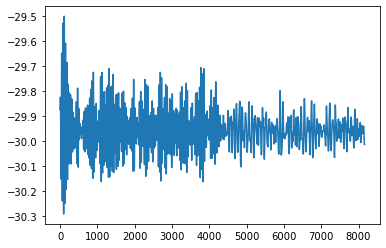

In [4]:
# Here an example for plotting an aspect of the data
plt.plot(integration.lever_arm_pos_tx[2,:])

Add the solve() method

If no projection has been chosen determine the mean latitude. Look up the latitude range for which UTM may be used. If the mean latitude falls within this range use the UTM projection with orthometric references, otherwise generate an 

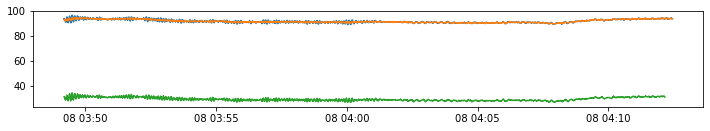

In [5]:
integration.draw()